Pathway identification workflow related to DataCure and AOPlink case studies

This notebook downloads TG-Gates data of some compounds and selects genes overexpressed in all sample. The Affymetrix probe sets are then translated into Ensembl gene identifiers using the BridgeDB service and pathways associated with the genes are identified using the WikiPathways service.


In this coding block all the necessary python packages to run the notebook, are imported. 

In [2]:
# Here are the packages imported in to the program. (be sure that the are installed).
import requests
import pandas
import urllib

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display, HTML
from SPARQLWrapper import SPARQLWrapper, JSON

Of the four online web services that will be used in this notebook, three will be directly stored as simple string variables, in this coding block.
 So that the can be used in different coding blocks.

In [3]:
# Here are the three url's, of the web-page's that will be used, stored as variables.. 
chemidconvert = 'https://chemidconvert.cloud.douglasconnect.com/v1/'
tggatesconvert = 'http://open-tggates-api.cloud.douglasconnect.com/v2/'
bridgedb = "http://bridgedb.prod.openrisknet.org/Human/xrefs/X/"

Now the compounds to use are chosen, by putting there name in to the `compuntset`.

In [4]:
"""This set, contains the chemical names of the compound that are used in this notebook.
To research different compounds, you need to change the names.
"""
compoundset = {'paracetamol', 'acetominophen', 'methapyrilene', 'phenylbutazone', 'simvastatin', 'valproic acid'}

Here is a data frame constructed with the compound name, smile, and image. This is accomplished with the use of the web service of the variable `chemiconvert`, and multiple imported python packages.

In [5]:
pandas.set_option('display.max_colwidth', -1)  # Make the table.
compounds = pandas.DataFrame(columns=['Compound name', 'Smiles', 'Image'])

# Fill "compounds" with the "smiles" by the compound name.
for compound in compoundset:
    smiles = requests.get(chemidconvert + 'name/to/smiles', params={'name': compound}).json()['smiles']
    compounds = compounds.append({'Compound name': compound, 'Smiles': smiles, 'Image': smiles}, ignore_index=True)


def smiles_to_image_html(smiles):  # "smiles" shadows "smiles" from outer scope, use this function only in "to_html().
    """Gets for each smile the image, in HTML.
    :param smiles: Takes the “smiles” form “compounds”.
    :return: The HTML code for the image of the given smiles.
    """
    return '<img style="width:150px" src="' + chemidconvert+'asSvg?smiles='+urllib.parse.quote(smiles)+'"/>'


# Return a HTML table of "compounds", after "compounds" is fill by "smiles_to_image_html".
HTML(compounds.to_html(escape=False, formatters=dict(Image=smiles_to_image_html)))

,Compound name,Smiles,Image
0,simvastatin,CCC(C)(C)C(=O)O[C@H]1C[C@@H](C)C=C2C=C[C@H](C)[C@H](CC[C@@H]3C[C@@H](O)CC(=O)O3)[C@@H]12,
1,phenylbutazone,CCCCC1C(=O)N(N(C1=O)c2ccccc2)c3ccccc3,
2,valproic acid,CCCC(CCC)C(O)=O,
3,acetominophen,None,None
4,paracetamol,CC(=O)Nc1ccc(O)cc1,
5,methapyrilene,CN(C)CCN(Cc1sccc1)c2ccccn2,


Here the data wits will be investigated is donloadid from the  web (the gen expression from TG-Gates). As you can see in the code, the default is that the compound comes from human liver. As last a part of the gotten data is shown as data frame.

In [6]:
# Get the names from "compoundset" and put a “|” between them for the "TGGATES".                                         
compounds_name = "|".join(compoundset)
compounds_name

#  Get more information from the "TGGATES" about the compounds by "compounds_name".                                      
r2 = requests.get(tggatesconvert + 'samples',
                  params={'limit': 10000, 'compoundNameFilter': compounds_name,
                          'organismFilter': 'Human', 'tissueFilter': 'Liver',
                          'cellTypeFilter': 'in vitro', 'repeatTypeFilter': 'Single',
                          'timepointHrFilter': '24.0', 'doseLevelFilter': 'High'
                          })

# The "TGGATES" status code is printed and, verified if it is 200; and thereafter transform to a jason. 
# The "TGGATES" status code is printed, to show the user that it is "200" (or not).
print("TGGATES Status code: " + str(r2.status_code))
samples = None
if r2.status_code == 200:  # It is checked whether the status code is "200".                                                                                              
    samples = r2.json()  # the received data from "TGGATES" is stored in the variable "samples" as json format.                                                                                             
    # Print the 'samples' information of the "samples" as a data frame.                                                      
    print(pandas.DataFrame(samples['samples']))
else:
    print("samples has not been created, because the TGGATES status code was not 200. The code will now exit.")
    exit(1)


TGGATES Status code: 200
           _id_  cellType    compoundName controlSamples doseLevel organism  \
0  003016020014  in vitro  methapyrilene   []             High      Human     
1  003016020015  in vitro  methapyrilene   []             High      Human     
2  003016014002  in vitro  phenylbutazone  []             High      Human     
3  003016014003  in vitro  phenylbutazone  []             High      Human     
4  003016079002  in vitro  simvastatin     []             High      Human     
5  003016079003  in vitro  simvastatin     []             High      Human     
6  003016038010  in vitro  valproic acid   []             High      Human     
7  003016038011  in vitro  valproic acid   []             High      Human     

  repeatType      sampleId  timepointHr tissue  
0  Single     003016020014  24.0         Liver  
1  Single     003016020015  24.0         Liver  
2  Single     003016014002  24.0         Liver  
3  Single     003016014003  24.0         Liver  
4  Single     0030

This block downloads even more information from  TG-Gates. And stored in a preparation to work with the fold changes.

In [7]:
# Again contact is maid with "TGGATES" to get more information from the samples.


#  The important variable "foldchanges" (which will be used till the last coding block) is made. 
foldchanges = pandas.DataFrame


for sample in samples["samples"]:
    sampleId = sample["sampleId"]
    sampleName = sample["compoundName"] + "\n" + sample["sampleId"]
    r3 = requests.get(tggatesconvert+'results',
                      params={'limit': 'none', 'sampleIdFilter': sampleId,
                              'valueTypeFilter': 'log2fold', 'pValueMax': '0.1'})  # The query is execute.

    """The  status code of the query is checked,
    and a temporarily data frame ("df") is created,
    to store the results of the query.
    """
    df = None
    if r3.status_code == 200:
        data = r3.json()
        df = pandas.DataFrame(data['results'])
        df = df.filter(items=['assayId', 'value'])
        df.columns = ['ProbeSet', sampleName]
    else:
        print("samples has not been created, because the TGGATES Status code was not 200. The code will now exit.")
        exit(1)
    
    # Every Temporarily data frame is added to  "foldchanges".
    if foldchanges.empty:
        foldchanges = df
    else:
        foldchanges = pandas.merge(foldchanges, df, how='outer', on=['ProbeSet'])

In this block, each fold changes is compared to one. end only kept if is higher than one, and previous was also kept.

In [8]:
"""The variable "high" is set to be "true",
so that the "Bitwise Operator" "&" is true, as long as the foldchanges are not higher then 1
"""
high = True 

# Compare the fold change of the "samples", and chose the highest.
for sample in samples["samples"]:
    high = high & (foldchanges[sample["compoundName"] + "\n" + sample["sampleId"]] >= 1)

foldchanges = foldchanges[high]

The selected fold changes.

In [9]:

foldchanges

,ProbeSet,methapyrilene 003016020014,methapyrilene 003016020015,phenylbutazone 003016014002,phenylbutazone 003016014003,simvastatin 003016079002,simvastatin 003016079003,valproic acid 003016038010,valproic acid 003016038011
217,243015_at,3.550345,3.607312,5.363620,5.425791,2.572754,2.564547,3.676939,3.807503
1105,229477_at,2.330954,2.191222,3.304727,3.415220,4.319531,4.132099,4.195705,3.802112
1106,229476_s_at,2.633772,2.882779,3.941051,3.899513,4.813974,4.702100,4.504707,4.460230
1376,227909_at,1.707718,1.954088,1.283314,1.484967,1.384484,1.640825,2.397012,2.142758
5361,208928_at,1.113596,1.250744,1.776669,1.682174,1.458460,1.429573,1.624269,1.398186
5604,207275_s_at,1.071509,1.147782,1.492939,1.539038,1.506103,1.431030,1.911157,1.826470
5764,205999_x_at,2.640015,2.349996,5.827156,5.702978,4.350264,4.210010,4.211109,3.934326
5773,205939_at,3.221563,3.000548,5.963379,5.733314,4.347017,4.373431,3.426144,3.077940
6991,201627_s_at,2.507150,2.567229,2.178763,2.132357,2.298643,2.169345,1.799169,1.656467
6993,201625_s_at,2.420876,2.454265,2.004699,2.082050,2.157720,2.225040,1.357678,1.223833


This line works a little bit like an import, it makes it possible to show the heat map of the next coding block. 

In [10]:
% matplotlib inline

Make a heat map of the probes in the fold changes.

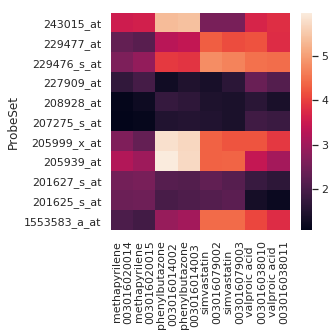

In [12]:
# Makes the heat map.
for_vis = foldchanges.set_index('ProbeSet')
plt.figure(figsize=(4, 4))
sns.set(font="Dejavu sans")
sns_plot = sns.heatmap(for_vis)  # type: object
sns_plot

Convertion of probe sets to Ensembl gene identifiers

In [13]:
#  Get the "Ensembl" and the "HGNC" in "foldchanges" as columns.
da = "?dataSource="  # The final part part to finis the url.
foldchanges['Ensembl'] = foldchanges.ProbeSet.apply(lambda url: requests.get(bridgedb+url+da+"En").text.split("\t")[0])
foldchanges['HGNC'] = foldchanges.ProbeSet.apply(lambda url: requests.get(bridgedb+url+da+"H").text.split("\t")[0])

Show the selected fold changes.

In [14]:
foldchanges

,ProbeSet,methapyrilene 003016020014,methapyrilene 003016020015,phenylbutazone 003016014002,phenylbutazone 003016014003,simvastatin 003016079002,simvastatin 003016079003,valproic acid 003016038010,valproic acid 003016038011,Ensembl,HGNC
217,243015_at,3.550345,3.607312,5.363620,5.425791,2.572754,2.564547,3.676939,3.807503,ENSG00000106258,CYP3A5
1105,229477_at,2.330954,2.191222,3.304727,3.415220,4.319531,4.132099,4.195705,3.802112,ENSG00000151365,THRSP
1106,229476_s_at,2.633772,2.882779,3.941051,3.899513,4.813974,4.702100,4.504707,4.460230,ENSG00000151365,THRSP
1376,227909_at,1.707718,1.954088,1.283314,1.484967,1.384484,1.640825,2.397012,2.142758,ENSG00000196972,SMIM10L2B
5361,208928_at,1.113596,1.250744,1.776669,1.682174,1.458460,1.429573,1.624269,1.398186,ENSG00000127948,POR
5604,207275_s_at,1.071509,1.147782,1.492939,1.539038,1.506103,1.431030,1.911157,1.826470,ENSG00000151726,ACSL1
5764,205999_x_at,2.640015,2.349996,5.827156,5.702978,4.350264,4.210010,4.211109,3.934326,ENSG00000160868,CYP3A4
5773,205939_at,3.221563,3.000548,5.963379,5.733314,4.347017,4.373431,3.426144,3.077940,ENSG00000160870,CYP3A7
6991,201627_s_at,2.507150,2.567229,2.178763,2.132357,2.298643,2.169345,1.799169,1.656467,ENSG00000186480,INSIG1
6993,201625_s_at,2.420876,2.454265,2.004699,2.082050,2.157720,2.225040,1.357678,1.223833,ENSG00000186480,INSIG1


In the following blocks the selected gens (from the fold changes) are used to find correlating pathways.

First a variable will be defined for the web services. But since the services expect a sparql query. The variable is a sparql wrapper object, instead of a string.

In [15]:
# SPARQLWrapper makes it possible to use sparql queries on the web-page.
sparql = SPARQLWrapper("http://sparql.wikipathways.org")

First the queries are made for each gene. If a query is made, it is executed online, and the results are stored.

In [16]:
# This is the creation of a data frame to store and represent data created in this coding block.
pathways = pandas.DataFrame(columns=['Gene', 'Ensembl', 'Pathway', 'Pathway Res', 'Pathway Title'])

genes = foldchanges['Ensembl']  # Here we continue with the "foldchanges".
results = None
for gene in genes:
    # Here the queries are made en the results are stored in "results".
    pathwayQuery = '''
      SELECT DISTINCT ?ensembl ?pathwayRes (str(?wpid) as ?pathway) (str(?title) as ?pathwayTitle)
      WHERE {{
        ?gene a wp:GeneProduct ;
          dcterms:identifier ?id ;
          dcterms:isPartOf ?pathwayRes ;
          wp:bdbEnsembl <http://identifiers.org/ensembl/{0}> .
        ?pathwayRes a wp:Pathway ;
          dcterms:identifier ?wpid ;
          dc:title ?title .
        BIND ( "{0}" AS ?ensembl )
      }}
    '''.format(gene)
    sparql.setQuery(pathwayQuery)
    sparql.setReturnFormat(JSON)  # Here the queries are made en the results are stored in "results".
    results = sparql.query().convert()

    for result in results["results"]["bindings"]:
        pathways = pathways.append({
            'Gene': foldchanges.loc[foldchanges['Ensembl'] == gene].iloc[0]["HGNC"],
            'Ensembl': result["ensembl"]["value"],
            'Pathway': result["pathway"]["value"],
            'Pathway Res': result["pathwayRes"]["value"],
            'Pathway Title': result["pathwayTitle"]["value"],
        }, ignore_index=True)


And finally the results, whit the selected pathways.

In [17]:
pathways

,Gene,Ensembl,Pathway,Pathway Res,Pathway Title
0,CYP3A5,ENSG00000106258,WP1197,http://identifiers.org/wikipathways/WP1197_r93222,Irinotecan Pathway
1,CYP3A5,ENSG00000106258,WP124,http://identifiers.org/wikipathways/WP124_r93209,Irinotecan Pathway
2,CYP3A5,ENSG00000106258,WP475,http://identifiers.org/wikipathways/WP475_r93210,Irinotecan Pathway
3,CYP3A5,ENSG00000106258,WP691,http://identifiers.org/wikipathways/WP691_r92400,Tamoxifen metabolism
4,CYP3A5,ENSG00000106258,WP2875,http://identifiers.org/wikipathways/WP2875_r94791,Constitutive Androstane Receptor Pathway
5,CYP3A5,ENSG00000106258,WP2877,http://identifiers.org/wikipathways/WP2877_r94793,Vitamin D Receptor Pathway
6,CYP3A5,ENSG00000106258,WP2876,http://identifiers.org/wikipathways/WP2876_r94905,Pregnane X Receptor pathway
7,CYP3A5,ENSG00000106258,WP43,http://identifiers.org/wikipathways/WP43_r94176,Oxidation by Cytochrome P450
8,CYP3A5,ENSG00000106258,WP2882,http://identifiers.org/wikipathways/WP2882_r97489,Nuclear Receptors Meta-Pathway
9,CYP3A5,ENSG00000106258,WP229,http://identifiers.org/wikipathways/WP229_r96294,Irinotecan Pathway
